Federico Manenti: 790032

Matteo Licciardello: 799368

# Retrieval

## Import

### Librerie

In [1]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 6.4MB/s 


In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-038546q3
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-038546q3
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=9bd5fb55f5a9a0768010ca9f5ccc58cc652966ca77f4214d41cc9966cad08fed
  Stored in directory: /tmp/pip-ephem-wheel-cache-v00dvgzm/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [3]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import librosa
import joblib
import librosa.display as lid
from sklearn.preprocessing import scale
from tqdm import tqdm

import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras import layers, optimizers, callbacks, Model, losses, models
from keras.preprocessing import image as kimage

from sklearn.neighbors import KDTree
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Dati

In [0]:
#Definisco la directory nel mio Drive da cui saranno prelevati i dati (nelle tre diverse cartelle) 
dir_drive = "/content/drive/My Drive/progetto_dsim/data/facce/"

#Definisco le categorie associate alle cartelle-immagini
category = ["fede", "liccia"]

In [0]:
# Da cambiare ogni volta
!wget https://sd8mug.dm.files.1drv.com/y4mfC6QKdwaXZI4oU02982HUE2bpsfxfCoFxLlIZhAvg9pJ-KQNSmgD8VvETGwa1rhovm9bNL_xxP2m5NZXTSX8Mi_KMJYojKtG9q_EmIBMX-lsJNCzdzsldghp9fpSfGmP9YYDJLkuw08kZ7wi09LZ2Et9T8Hsq3n8o91QrfuJHeg7BrCLoVWn1IOmUr90jfdq/thumbnails_features_deduped_publish.zip?download&psid=1

--2020-02-12 16:53:29--  https://sd8mug.dm.files.1drv.com/y4mfC6QKdwaXZI4oU02982HUE2bpsfxfCoFxLlIZhAvg9pJ-KQNSmgD8VvETGwa1rhovm9bNL_xxP2m5NZXTSX8Mi_KMJYojKtG9q_EmIBMX-lsJNCzdzsldghp9fpSfGmP9YYDJLkuw08kZ7wi09LZ2Et9T8Hsq3n8o91QrfuJHeg7BrCLoVWn1IOmUr90jfdq/thumbnails_features_deduped_publish.zip?download
Resolving sd8mug.dm.files.1drv.com (sd8mug.dm.files.1drv.com)... 13.107.42.12
Connecting to sd8mug.dm.files.1drv.com (sd8mug.dm.files.1drv.com)|13.107.42.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1394936834 (1.3G) [application/zip]
Saving to: ‘thumbnails_features_deduped_publish.zip?download’

thumbnails_features 100%[===================>]   1.30G  16.7MB/s    in 70s     

2020-02-12 16:54:40 (19.0 MB/s) - ‘thumbnails_features_deduped_publish.zip?download’ saved [1394936834/1394936834]



In [0]:
%%capture

!unzip "/content/thumbnails_features_deduped_publish.zip?download"

In [0]:
!mv /content/thumbnails_features_deduped_publish /content/celebrity_dataset

## VGG-Face

In [8]:
# resnet on face
IMG_SIZE = 255
net = VGGFace(model='resnet50',
              include_top=False,
              pooling='avg',
              input_shape=(IMG_SIZE, IMG_SIZE, 3))

94699520/94694792 [==============================] - 3s 0us/step


In [0]:
net.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 255, 255, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 128, 128, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 128, 128, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

## Preprocessing

### Estrazione path

In [0]:
face_detector = cv.CascadeClassifier('/content/drive/My Drive/progetto_dsim/haarcascade_frontalface_default.xml')

In [0]:
# Troviamo le immagini con solo 1 faccia 

def cleen_data():

    base_path = '/content/celebrity_dataset/'

    for f in tqdm(sorted(os.listdir(base_path))):
        path = os.path.join(base_path, f)
        for fi, i in enumerate(os.listdir(path)):
            
            try:
                if i.endswith('.jpg'): # and fi < maximages:
                    # Memorizza percorso file
                    cur_path = path + '/' + i 
                    
                    # Carica file controllo se è presente una faccia
                    img_array = cv.imread(cur_path,cv.IMREAD_GRAYSCALE)  # convert to array
                    img_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    face = face_detector.detectMultiScale(img_array)
                    if (len(face) == 1):
                        paths.append(cur_path)
            except Exception as e:  # in the interest in keeping the output clean...
                pass

In [0]:
paths = []
cleen_data()

In [0]:
joblib.dump(paths, "/content/drive/My Drive/progetto_dsim/consegna/celebrity_path.joblib")

['/content/drive/My Drive/progetto_dsim/celebrity_path_one_face_last.joblib']

In [0]:
celebrity_path = joblib.load("/content/drive/My Drive/progetto_dsim/consegna/celebrity_path.joblib")

### Estrazione features

In [0]:
def neural_features(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x, version=2)
    f = net.predict(x)
    return f.flatten()

def create_data(search_path, feature_extractor):
    for i in tqdm(search_path):
        image = kimage.load_img(i, target_size=(IMG_SIZE, IMG_SIZE, 3))
        cur_features = feature_extractor(image)
        features.append(cur_features)

In [18]:
features = []
create_data(search_path = celebrity_path, feature_extractor=neural_features)

  0%|          | 0/155695 [00:00<?, ?it/s]


FileNotFoundError: ignored

In [0]:
joblib.dump(features, "/content/drive/My Drive/progetto_dsim/consegna/celebrity_features.joblib")

['/content/drive/My Drive/progetto_dsim/celebrity_features_one_face_last.joblib']

In [0]:
features = joblib.load("/content/drive/My Drive/progetto_dsim/consegna/celebrity_features.joblib")

## Ricerca

### Creazione albero

In [0]:
tree = KDTree(np.array(features))

In [0]:
joblib.dump(tree, "/content/drive/My Drive/progetto_dsim/consegna/celebrity_tree.joblib")

['/content/drive/My Drive/progetto_dsim/celebrity_tree_one_face_last.joblib']

In [0]:
tree = joblib.load("/content/drive/My Drive/progetto_dsim/consegna/celebrity_tree.joblib")

### Controllo validità albero

Utilizzo una foto non presente nel dataset di una celebrità contenuta nel dataset per controllare se verrà restituila lei stessa come immagine più simile

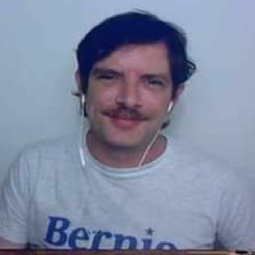

In [10]:
famous = kimage.load_img("/content/photo5906856939118245019.jpg", target_size=(IMG_SIZE, IMG_SIZE, 3))
famous

In [0]:
famous_features = create_feat(famous)
_, famous_ind = tree.query(famous_features, k=10)

In [25]:
for i in famous_ind[0]:
    plt.figure()
    plt.imshow(kimage.load_img(celebrity_path[i]))
    plt.title(celebrity_path[i].split('/')[3], fontsize=20)

FileNotFoundError: ignored

<Figure size 432x288 with 0 Axes>

### Query

In [0]:
def create_feat(img):
    img_features = kimage.img_to_array(img)
    img_features = np.expand_dims(img_features, axis=0)
    img_features = utils.preprocess_input(img_features, version=2)
    img_features = net.predict(img_features)
    return (img_features)

def find(feat):
    dist, ind = tree.query(feat, k=20)
    return (dist, ind)

def retrieval(ind, ind_len):
    top_img = []
    top_name = []
    i = 0
    for k in ind[0]:
        name = celebrity_path[k].split('/')
        if name[3] not in top_name and len(top_img) < 10:
            top_name.append(name[3])
            top_img.append(kimage.load_img(celebrity_path[ind[0][i]]))
        i += 1
    return (top_img, top_name)

def printsim(lst_top, ind):
    ## Stampa nome
    for i in ind[0]:
        txt = celebrity_path[i]
        x = txt.split('/')
        print(x[3])

def printface(lst_top):
    for i in range(0, len(lst_top)):
        plt.figure()
        plt.imshow(lst_top[i])
        plt.title(top_name[i], fontsize=20)

#### Risultati Federico

In [0]:
fede = kimage.load_img("/content/drive/My Drive/progetto_dsim/data/facce/fede/8.png",  
                       target_size=(IMG_SIZE, IMG_SIZE, 3))

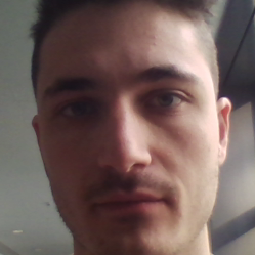

In [0]:
fede

In [0]:
fede_features = create_feat(fede)
fede_dist, fede_ind = tree.query(fede_features, k=20)
top_foto, top_name = retrieval(fede_ind, len(fede_ind[0]))

In [0]:
print(top_name)

['gerard butler', 'orlando bloom', 'james franco', 'rodrigo santoro', 'shia labeouf', 'nicole richie', 'leonardo dicaprio', 'robbie williams', 'john mayer', 'tiziano ferro']


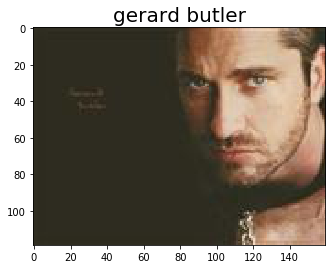

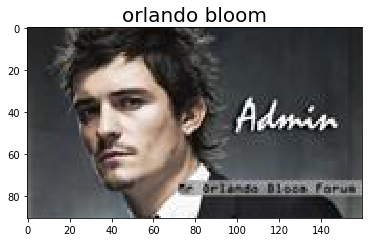

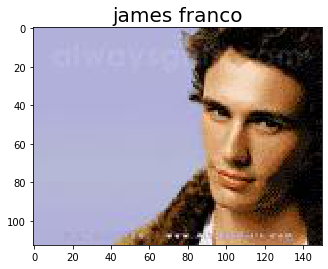

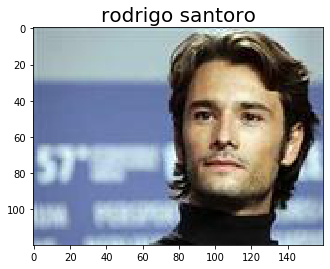

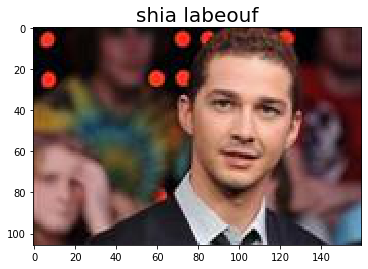

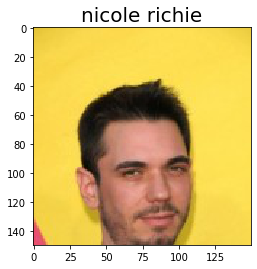

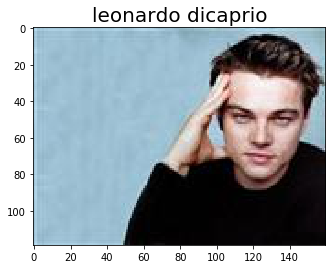

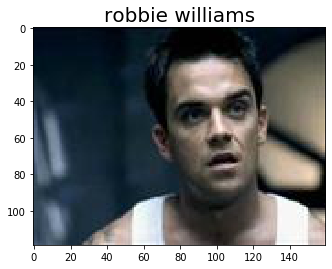

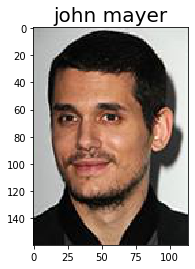

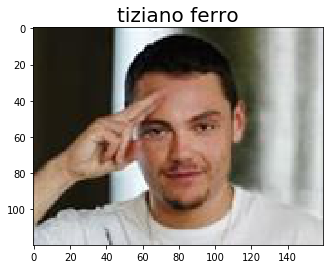

In [0]:
printface(top_foto)

#### Risultati Matteo

In [0]:
liccia = kimage.load_img("/content/drive/My Drive/progetto_dsim/data/facce/liccia/10.png",  
                       target_size=(IMG_SIZE, IMG_SIZE, 3))

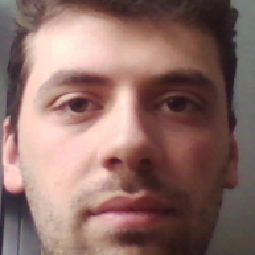

In [0]:
liccia

In [0]:
liccia_features = create_feat(liccia)
liccia_dist, liccia_ind = tree.query(liccia_features, k=20)
top_foto, top_name = retrieval(liccia_ind, len(liccia_ind[0]))

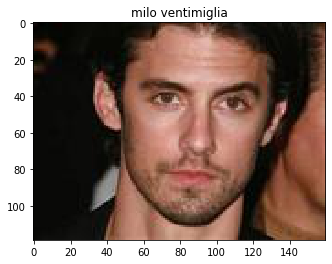

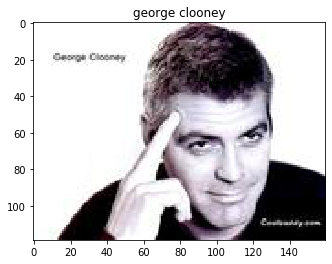

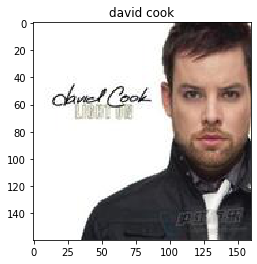

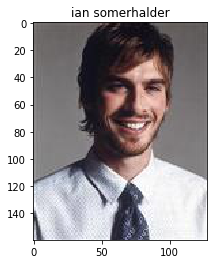

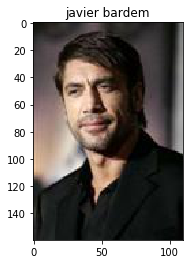

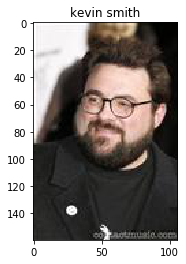

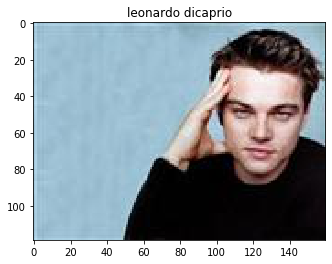

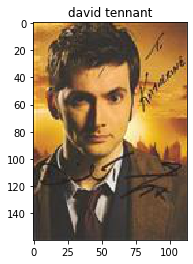

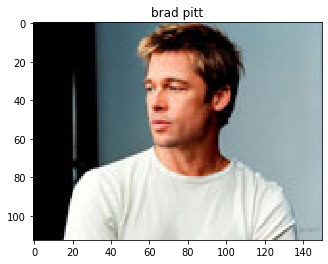

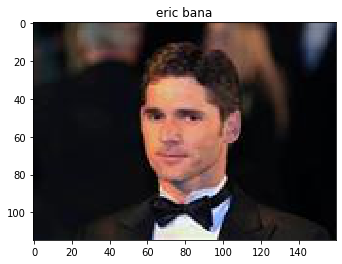

In [0]:
printface(top_foto)